# IPython (Jupyter) widgets: An image convolution demo

Convolution is one of the fundamental concepts of image processing (and more generally, signal processing). For the [`scikit-image` tutorial at Scipy 2014](http://tonysyu.github.io/scikit-image-tutorial-at-scipy-2014.html), I created an IPython widget to help visualize convolution. This post explains that widget in more detail.

Very little of this post is actually about using the widget API: The [IPython notebook widgets](http://nbviewer.ipython.org/github/ipython/ipython/blob/master/examples/Interactive%20Widgets/Index.ipynb) have a really easy-to-use API, so only a small bit of code is necessary. That said, I think this makes for a really nice demo of both image convolution and the usefulness of IPython widgets.

### Requirements

If you want run this notebook ([Download Notebook](http://tonysyu.github.io/includes/Image_convolution_demo.ipynb)), you'll need:

- [IPython](http://ipython.org/) >= 5.1.0 (earlier versions probably work)
- [matplotlib](http://matplotlib.org/) >= 2.0.0 (earlier versions probably work)
- [scikit-image](http://scikit-image.org/) >= 0.12 

In particular this has been tested to work with the [Anaconda Python Distribution](https://www.continuum.io/downloads) version 4.3.1 based on Python 3.6

### Aside about plotting...

Before we get started, let's define a bit of boilerplate that's useful for any IPython notebook dealing with images:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

I *highly* recommended setting the default colormap to 'gray' for images and pretty much everything else. (There are, however, exceptions, as you'll see below.) Also, using nearest neighbor interpolation (which is what 'none' does for zoomed-in images) makes pixel boundaries clearer.

## Image convolution

The basic idea of image convolution is that you take an image like this:

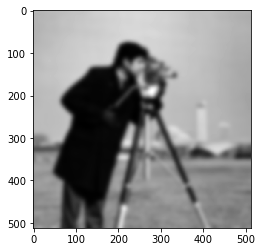

In [3]:
from skimage import data, filters

image = data.camera()
# Ignore the Gaussian filter, for now.
# (This is explained at the end of the article.)
smooth_image = filter.gaussian(image, 5)
plt.imshow(smooth_image);

... and filter the image using a convolution "kernel" that looks like this:

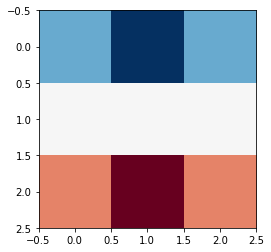

In [4]:
import numpy as np

horizontal_edge_kernel = np.array([[ 1,  2,  1],
                                   [ 0,  0,  0],
                                   [-1, -2, -1]])
# Non-gray colormap to color negative values (red) and positive values (blue)
plt.imshow(horizontal_edge_kernel, cmap=plt.cm.RdBu);

... to arrive at a result that looks like this:

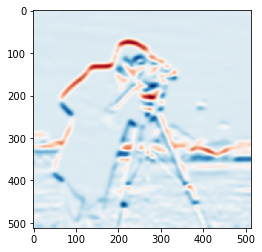

In [5]:
from scipy.ndimage import convolve

horizontal_edge_response = convolve(smooth_image, horizontal_edge_kernel)
plt.imshow(horizontal_edge_response, cmap=plt.cm.RdBu);

As the variable names suggest, this filter highlights the horizontal edges of an image. We'll see what's happening here later on.

(Note that the coloring in the kernel and the filtered image come from the colormap that's used---the output is still a grayscale image. The red just means that a value is negative, and the blue is positive.)

## An IPython widget for demonstrating image convolution

We're going to develop an IPython widget that looks something like this:

![Image of convolution widget](convolution_demo_widget.png)

The slider in the widget allows you to step through the convolution process for each pixel in an image. The image (a white square with a black background) we use for the demo is really boring, just so the filtering process is clearer.

The plot on the left shows the original, unfiltered, image. On top of that, we overlay the kernel position: The center pixel of the kernel is tinted red, and the remaining pixels in the kernel are tinted yellow. The red pixel is the one being altered by the current step of the convolution procedure, while red and yellow pixels are used to determine the replacement value.

On the left, we see the image at the `i`th step of the convolution process, which gives the (partially) filtered result.

Before we get started though, let's define some helper functions.

## Some helper functions

Helper functions are great: They make code much more readable and reusable, which is what we should all be striving for. It's not necessary to understand these functions right away. You can easily skip over this for now, and revisit it if you have questions about the actual widget implementation. The function names, themselves, should be enough to describe their... ahem... functionality (except for `iter_kernel_labels`, that one's tough to describe succintly).

### Iterate over pixels with `iter_pixels`

First of all, we're going to want to look at the individual pixels of an image. So, let's define an iterator (or actually a generator) to make that easy:

In [6]:
def iter_pixels(image):
    """ Yield pixel position (row, column) and pixel intensity. """
    height, width = image.shape[:2]
    for i in range(height):
        for j in range(width):
            yield (i, j), image[i, j]

This "yields" the row, column, and pixel value for each iteration of a loop. By the way: You wouldn't normally loop over pixels (since Python loops are a bit slow) but the whole point of this widget is to go step-by-step.

### Showing images side-by-side with `imshow_pair`

Like I said, I like small utility functions, so I pulled out the code to plot side-by-side images into its own function:

In [7]:
def imshow_pair(image_pair, titles=('', ''), figsize=(10, 5), **kwargs):
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    for ax, img, label in zip(axes.ravel(), image_pair, titles):
        ax.imshow(img, **kwargs)
        ax.set_title(label)

### Dealing with boundary conditions

What's the hardest part of any math problem (discrete, or otherwise)?

Boundary conditions! (That's what they tell engineers, at least. If you're doing "real" math that's probably not true. Actually, even if that's not the case, it's probably not true.)

There are many different solutions to dealing with boundaries; what we're going to do is just pad the input image with zeros based on the size of the kernel.

#### Calculating border padding with `padding_for_kernel`

First we define, a utility function to figure out how much padding to add based on the kernel shape. Basically, this just calculates the number of pixels that extend beyond the center pixel:

In [8]:
def padding_for_kernel(kernel):
    """ Return the amount of padding needed for each side of an image.
    
    For example, of the returned result is [1, 2], then this means an 
    image should be padded with 1 extra row on top and bottom, and 2
    extra columns on the left and right.
    """
    # Slice to ignore RGB channels if they exist.
    image_shape = kernel.shape[:2]
    # We only want to handle kernels with odd dimensions so make sure that's true.
    # (If a dimension is not odd, then the "center" pixel is a bit arbitrary.)
    assert all((size % 2) == 1 for size in image_shape)
    return [(size - 1) // 2 for size in image_shape]

#### Padding an image border with `add_padding`

Then we define another utility funciton that uses the above function to pad the border of an image with zeros:

In [9]:
def add_padding(image, kernel):
    h_pad, w_pad = padding_for_kernel(kernel)
    return np.pad(image, ((h_pad, h_pad), (w_pad, w_pad)),
                  mode='constant', constant_values=0)

#### Reverse `add_padding` with `remove_padding`

And sometimes, we need to take the padded image (or more likely, a filtered version of the padded image), and trim away the padded region, so we define a funtion to remove padding based on the kernel shape:

In [10]:
def remove_padding(image, kernel):
    inner_region = []  # A 2D slice for grabbing the inner image region
    for pad in padding_for_kernel(kernel):
        slice_i = slice(None) if pad == 0 else slice(pad, -pad)
        inner_region.append(slice_i)
    return image[inner_region]

#### Padding demo

Just to make those functions a bit clearer, let's run through a demo. If you have an image that has a shape like:

In [11]:
image = np.empty((10, 20))
image.shape

(10, 20)

... and a kernel that has a shape like:

In [12]:
kernel = np.ones((3, 5))
kernel.shape

(3, 5)

... adding padding to the image gives:

In [13]:
padded = add_padding(image, kernel)
padded.shape

(12, 24)

Note that the total amount of padding is actually one less than the kernel size since you only need to add padding for *neighbors* of the center pixel, but not the center pixel, itself. (If this isn't clear, hopefully it will become clear when we start visualizing.)

And of course, using `remove_padding` gives us the original shape:

In [14]:
remove_padding(padded, kernel).shape

(10, 20)

### Slicing into the image with `window_slice`

We're going to iterate over the pixels of an image and apply the convolution kernel in the 2D neighborhood (i.e. "window") of each pixel. To that end, it really helps to have an easy way to slice into an image based on the center of the kernel and the kernel shape, so here's a pretty simple way of doing that:

In [15]:
def window_slice(center, kernel):
    r, c = center
    r_pad, c_pad = padding_for_kernel(kernel)
    # Slicing is (inclusive, exclusive) so add 1 to the stop value
    return [slice(r-r_pad, r+r_pad+1), slice(c-c_pad, c+c_pad+1)]

The `center` parameter is just the (row, column) index corresponding to the center of the image patch where we'll be applying the convolution kernel.

As a quick example, take a 2D array that looks like:

In [16]:
image = np.arange(4) + 10 * np.arange(4).reshape(4, 1)
print(image)

[[ 0  1  2  3]
 [10 11 12 13]
 [20 21 22 23]
 [30 31 32 33]]


We can use `window_slice` to slice-out a 3x3 window of our array as follows:

In [17]:
dummy_kernel = np.empty((3, 3))  # We only care about the shape
center = (1, 1)
print(image[window_slice(center, dummy_kernel)])

[[ 0  1  2]
 [10 11 12]
 [20 21 22]]


Note that the center pixel is 11, which corresponds to row 1, column 1 of the original array. We can increment the column to shift to the right:

In [18]:
print(image[window_slice((1, 2), dummy_kernel)])

[[ 1  2  3]
 [11 12 13]
 [21 22 23]]


Or increment the row to shift down:

In [19]:
print(image[window_slice((2, 1), dummy_kernel)])

[[10 11 12]
 [20 21 22]
 [30 31 32]]


Non-squre kernels would work too:

In [20]:
dummy_kernel = np.empty((3, 1))
print(image[window_slice((2, 1), dummy_kernel)])

[[11]
 [21]
 [31]]


### Applying the kernel to an image patch with `apply_kernel`

To actually "apply" the convolution kernel to an image patch, we just grab an image patch based on the center location and the kernel shape, and then "apply" the kernel by taking the sum of pixel intensities under the kernel, weighted by the kernel values:

In [21]:
def apply_kernel(center, kernel, original_image):
    image_patch = original_image[window_slice(center, kernel)]
    # An element-wise multiplication followed by the sum (i.e. a weighted average)
    return np.sum(kernel * image_patch)

Technically, convolution requires flipping the kernel horizontally and vertically, but that's not really an important detail here.

### Marking where the kernel is located with `iter_kernel_labels`

The whole point of this widget is to visualize how convolution works, so we need a way to display where the convolution kernel is located at any given iteration. To that end, we do a bit of array manipulation to mark:
* Pixels *under* the kernel with a value of 1
* The pixel at the center of the kernel with a value of 2
* All other pixels with a value of 0

In [22]:
def iter_kernel_labels(image, kernel):
    """ Yield position and kernel labels for each pixel in the image.

    The kernel label-image has a 2 at the center pixel and 1 for every other
    pixel "under" the kernel. Pixels not under the kernel are labeled as 0.
    
    Note that the mask is the same size as the input image.
    """
    original_image = image
    image = add_padding(original_image, kernel)
    i_pad, j_pad = padding_for_kernel(kernel)
    for (i, j), pixel in iter_pixels(original_image):
        # We padded the image so this shifts the center to the *original* location
        i += i_pad
        j += j_pad
        mask = np.zeros(image.shape, dtype=int)  # Background = 0
        mask[window_slice((i, j), kernel)] = 1   # Kernel = 1
        mask[i, j] = 2                           # Kernel-center = 2
        yield (i, j), mask

### Visualizing our kernel overlay with `visualize_kernel`

Now we want to take those 1s and 2s marking our kernel, and turn that into a color overlay. We do that using a little utility from scikit-image that overlays label values onto an image:

In [23]:
from skimage import color

def visualize_kernel(kernel_labels, image):
    """ Return an overlay image, where 1's will be yellow and 2's will be red.
    
    See `iter_kernel_labels` for info on the meaning of 1 and 2.
    """
    return color.label2rgb(kernel_labels, image, bg_label=0,
                           colors=('yellow', 'red'))

Here we mark the center value (2) as red and neighboring values (1) as yellow. The background value (0) is transparent.

## IPython widget demo

So all the above helper functions were just to get us to this point: Making our own IPython widget.

But before that (such a tease), here's a *really* basic example of IPython widgets, in case the concept is completely new to you.

### A very simple widget

To define your own IPython widget, all you need to do is pass a function and the argument(s) you want to control to `widgets.interact`. So a very simple example would just be:

In [26]:
from ipywidgets import widgets

def printer(i):
    print("i = {}".format(i))

widgets.interact(printer, i=(0, 10));

i = 5


Moving the slider changes the value printed by `printer`. The keyword argument, `i`, must match the argument name in `printer`; that's how slider value gets connected to the `printer` function.

### A stepper function for image convolution

For the real widget, we're going to combine all of the helper functions defined above. Unfortunately, there're a couple of things here that make the code a bit more complicated than I would like:

* First, I wanted to make something that's fairly reusable. To that end, the following code snippet creates a function that *returns* the function passed to `widgets.interact`. That way we can prep the image and cache results (see below).
  - This function-that-returns-a-function is called a closure. Here's a pretty good explanation of the concept: [Closure explanation](http://stackoverflow.com/a/141426/260303)

* I'm going to do a bit of work here to cache results so that the demo function only computes the filtered result for each pixel once. Basically, we iterate over pixels in order, so we can cache a result for a pixel, and then we reuse the result to compute the result for the next pixel.

In [28]:
def make_convolution_step_function(image, kernel, **kwargs):
    # Initialize generator since we're only ever going to iterate over a pixel
    # once, even if we step back.
    gen_kernel_labels = iter_kernel_labels(image, kernel)    
    
    image_cache = []
    image = add_padding(image, kernel)
    
    def convolution_step(i_step):
        """ Plot the original image and kernel-overlay next to the filtered image.
        
        For a given step, check if it's in the image cache. If not calculate all
        necessary images. Then plot the requested step result.
        """
        
        # Create all images up to the current step, unless they're already cached:
        while i_step >= len(image_cache):
            
            # For the first step (`i_step == 0`), the original image is the filtered image;
            # after that we look in the cache, which stores (`kernel_overlay`, `filtered`).
            filtered_prev = image if i_step == 0 else image_cache[-1][1]
            # We don't want to overwrite the previously filtered image:
            filtered = filtered_prev.copy()
            
            # Get the labels used to visualize the kernel
            center, kernel_labels = next(gen_kernel_labels)
            # Modify the pixel value at the kernel center
            filtered[center] = apply_kernel(center, kernel, image)
            # Take the original image and overlay our kernel visualization
            kernel_overlay = visualize_kernel(kernel_labels, image)
            # Save images for reuse.
            image_cache.append((kernel_overlay, filtered))

        # Before displaying, remove the padding we added to deal with boundary conditions
        # (Loop since each step has an original-image/kernel-verlay and a filtered image)
        image_pair = [remove_padding(each, kernel) for each in image_cache[i_step]]
        imshow_pair(image_pair, **kwargs)
        plt.show()
        
    return convolution_step  # <-- this is a function

Now we just initialize the stepper function and pass that to `widgets.interact`:

In [32]:
from ipywidgets.widgets import IntSlider
def interactive_convolution_demo(image, kernel, **kwargs):
    convolution_step = make_convolution_step_function(image, kernel, **kwargs)
    step_slider = IntSlider(min=0, max=image.size-1, value=0)
    widgets.interact(convolution_step, i_step=step_slider)

There's a bit of tweaking here just to get the slider widget to start off at zero, but that's not crucial. You could have used
```
widgets.interact(convolution_step, i_step=(0, image.size-1))
```
but that would start with the slider at the midpoint, which isn't ideal for this particular demo.

### Demo: Mean filtering

Before using this widget, let's define a really small image, which makes this demo easier to understand:

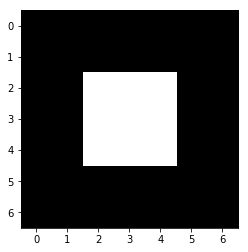

In [36]:
import numpy as np

bright_square = np.zeros((7, 7), dtype=float)
bright_square[2:5, 2:5] = 1
plt.imshow(bright_square);

One of the classic smoothing filters is the mean filter. As you might expect, it calculates the mean under the kernel. The kernel itself is just the weights used for the mean. For 3x3 kernel, this looks like:

In [37]:
mean_kernel = np.ones((3, 3), dtype=float)
mean_kernel /= mean_kernel.size
print(mean_kernel)

[[ 0.11111111  0.11111111  0.11111111]
 [ 0.11111111  0.11111111  0.11111111]
 [ 0.11111111  0.11111111  0.11111111]]


These weights will then be multiplied by pixel intensities using `apply_kernel`.

Using our convolution demo-widget, we can see how mean-filtering process looks, step-by-step:

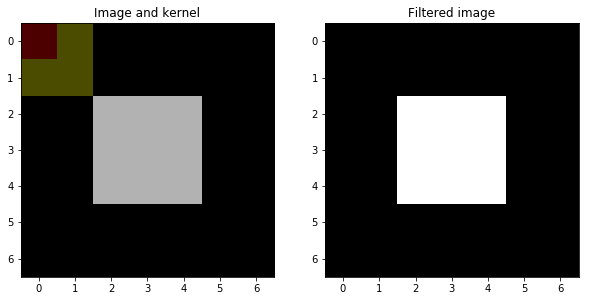

In [38]:
titles = ('Image and kernel', 'Filtered image')
interactive_convolution_demo(bright_square, mean_kernel, 
                             vmax=1, titles=titles)

**Boundary conditions, revisited:** If you look at `i_step = 0`, you can see why we went through the trouble of defining all that image-padding code: If we want to apply the convolution kernel to the top-left pixel, it has no neighbors above it or to the left. Adding padding (which was removed for display) allows us to handle those cases without too much trouble.

After playing around with the widget, you should notice that the mean kernel is really simple: 
- Weight each pixel under the kernel (red+yellow) equally
- Add all products (pixel-values × 1/9) together
- Replace center pixel (red) with the sum

In the filtered result, hard edges are smoothed: Since a pixel on an edge will be bordering both white and black pixels, the filtered result will be gray. This smoothing effect can be useful for blurring an image or removing noise (although [edge-preserving denoising filters](http://scikit-image.org/docs/dev/auto_examples/plot_denoise.html) are probably preferable).

### Demo: Edge filtering

Finally, let's look at another really useful and easy-to-understand filter: The edge filter. For images, edges are basically boundaries between light and dark values. An easy way to calculate that is to take the the difference of neighboring values.

Here, we'll use the Sobel kernel for detecting horizontal edges (which was defined at the very beginning):

In [39]:
print(horizontal_edge_kernel)

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]


Basically, using this kernel to calculate a weighted sum will subtract neighboring values *below* the center pixel from those *above* the center. If pixels above and below the center are the same, the filtered result is 0, but if they are very different, we get a strong "edge" response.

Again, using our convolution widget, we can step through the process quite easily:

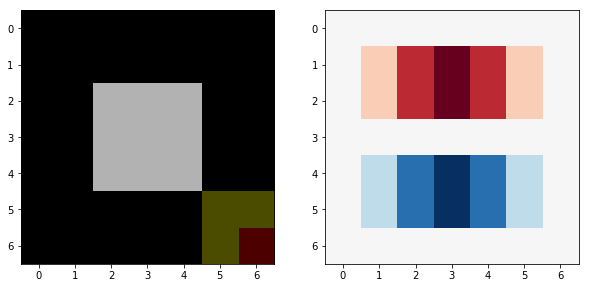

In [40]:
interactive_convolution_demo(bright_square, horizontal_edge_kernel,
                             vmin=-4, vmax=4, cmap=plt.cm.RdBu)

Play around with the widget a bit. You should notice that:
- This filter responds to horizontal edges (i.e. it is sensitive to the orientation of the edge)
- The filter responds differently when going from white-to-black vs black-to-white (i.e. it is sensitive to the direction of the edge)
- The edge response diminishes as it approaches a vertical boundary

Often, you don't really care about the orientation or direction of the edge. In that case, you would just combine the horizontal-edge filter with the corresponding vertical-edge filter and calculate the gradient magnitude. This is exactly what the standard [Sobel filter](http://scikit-image.org/docs/dev/auto_examples/plot_edge_filter.html) does.

I hope that clarifies the idea of convolution filters.

## Leftovers

* Q: Why did the first example use a `gaussian_filter`?
  - A: Edge filters (which are basically just derivatives) enhance noise. We do some smoothing beforehand to reduce the likelihood of false edges.
* Q: Why are the "edges" (the red and blue regions) in that last filtered image so thick?
  - A: The edge filter used here gives what's called a "centered difference". In reality, the edges lie in-between pixel values, so the closest we can get (without biasing the edge up or down) is to mark the pixels above and below the edge.
* Q: What do you mean by "neighbors" and "under" the kernel?
  - A: In the kernel overlay, red marks the center pixel, yellow marks the neighbors, and both red and yellow pixels are "under" the kernel.
* Really useful linear filters:
  - Gaussian filter <http://scikit-image.org/docs/dev/api/skimage.filter.html#gaussian-filter>, the classic smoothing filter
  - Sobel filter http://scikit-image.org/docs/dev/auto_examples/plot_edge_filter.html, for detection edges (a little different from the above since it takes the gradient magnitude, which means it doesn't care about direction or orientation)
* Useful generic filters:
  - Generic (local) filters work in a similar fashion to the convolution filters described above, but they aren't limited to a linear, weighted sum.
  - Denoising filters http://scikit-image.org/docs/dev/auto_examples/plot_denoise.html, for removing noise without smoothing edges
  - Rank (e.g. min, median, mode, max) filters http://scikit-image.org/docs/dev/auto_examples/applications/plot_rank_filters.html
  - Morphological filter http://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html, for manipulating shapes
* Scipy 2014 tutorial on scikit-image http://tonysyu.github.io/scikit-image-tutorial-at-scipy-2014.html
* This article in notebook form: [Download Notebook](http://tonysyu.github.io/includes/Image_convolution_demo.ipynb) (so you can actually use the widgets.)